In [19]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
from jax import random

In [20]:
def wait_time_model(wait_times):
    """M/M/1 queue"""
    rate = numpyro.sample("rate", dist.Gamma(1.0, 1.0))
    
    numpyro.sample("wait_times", 
                   dist.Exponential(rate=rate),
                   obs=wait_times)

In [21]:
# Synthetic data
key = random.PRNGKey(0)
true_rate = 0.5
synthetic_wait_times = np.random.exponential(scale=1/true_rate, size=100)

In [22]:
kernel = NUTS(wait_time_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(key, wait_times=synthetic_wait_times)
mcmc.print_summary()


sample: 100%|██████████| 3000/3000 [00:00<00:00, 3357.44it/s, 3 steps of size 1.12e+00. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      rate      0.52      0.05      0.51      0.43      0.59    788.37      1.00

Number of divergences: 0


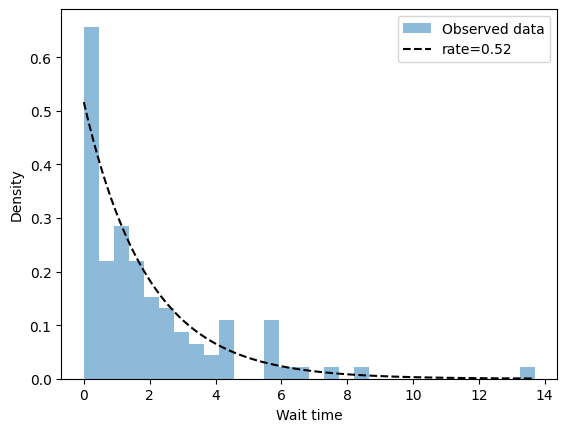

In [23]:
samples = mcmc.get_samples()
plt.figure()
plt.hist(
    synthetic_wait_times, 
    bins=30, 
    density=True, 
    alpha=0.5, 
    label='Observed data'
    )
    
x = np.linspace(0, max(synthetic_wait_times), 100)
rate_mean = np.mean(samples['rate'])
plt.plot(
    x, 
    rate_mean * np.exp(-rate_mean * x), 
    'k--', 
    label=f'rate={rate_mean:.2f}'
    )
    
plt.xlabel('Wait time')
plt.ylabel('Density')
plt.legend()
plt.show()

In [24]:
def weber_fechner_model(stimuli, responses):
    """Weber-Fechner law"""
    k = numpyro.sample("k", dist.LogNormal(0.0, 1.0))
    reference = numpyro.sample("reference", dist.LogNormal(0.0, 1.0))
    sigma = numpyro.sample("sigma", dist.LogNormal(0.0, 1.0))
    
    expected_response = k * jnp.log(stimuli / reference)
    
    numpyro.sample("responses",
                   dist.Normal(expected_response, sigma),
                   obs=responses)

In [25]:
stimuli = np.logspace(0, 2, 50)
true_k = 2.0
true_reference = 1.0
true_responses = true_k * np.log(stimuli / true_reference) + np.random.normal(0, 0.1, size=50)


In [26]:
kernel = NUTS(weber_fechner_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(key, stimuli=stimuli, responses=true_responses)
mcmc.print_summary()


sample: 100%|██████████| 3000/3000 [00:01<00:00, 2851.35it/s, 15 steps of size 3.81e-01. acc. prob=0.91]


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          k      2.01      0.01      2.01      1.99      2.02    827.08      1.00
  reference      1.00      0.01      1.00      0.98      1.02    740.94      1.00
      sigma      0.10      0.01      0.10      0.09      0.12    996.85      1.00

Number of divergences: 0


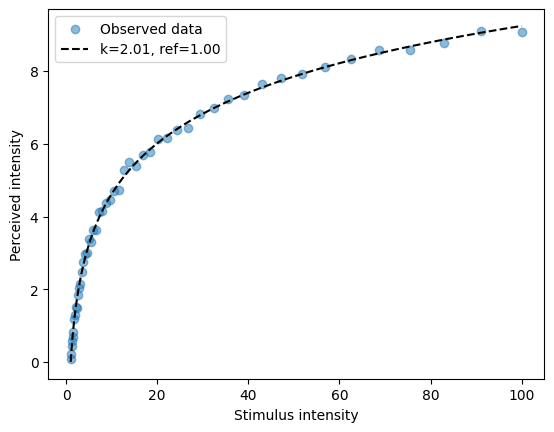

In [30]:
samples = mcmc.get_samples()
plt.figure()
    
plt.scatter(
    stimuli, 
    true_responses, 
    alpha=0.5, 
    label='Observed data'
    )
    
# Plot fitted curve
x = np.logspace(0, 2, 100)
k_mean = np.mean(samples['k'])
ref_mean = np.mean(samples['reference'])
plt.plot(
    x, 
    k_mean * np.log(x / ref_mean), 
    'k--',
    label=f'k={k_mean:.2f}, ref={ref_mean:.2f}'
    )
    
#plt.xscale('log')
plt.xlabel('Stimulus intensity')
plt.ylabel('Perceived intensity')
plt.legend()
plt.show()